<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [101]:
import biom
import pandas as pd
import numpy as np

import arviz as az
import matplotlib.pyplot as plt
%matplotlib inline

In [102]:
data_dir = '../data/amplicon_comparison'
inf_z = az.from_netcdf(f'{data_dir}/differentials_z.nc')
inf_d = az.from_netcdf(f'{data_dir}/differentials_d.nc')
inf_b = az.from_netcdf(f'{data_dir}/differentials_b.nc')

z_diff = inf_z['posterior']['diff'].to_dataframe()
d_diff = inf_d['posterior']['diff'].to_dataframe()
b_diff = inf_b['posterior']['diff'].to_dataframe()

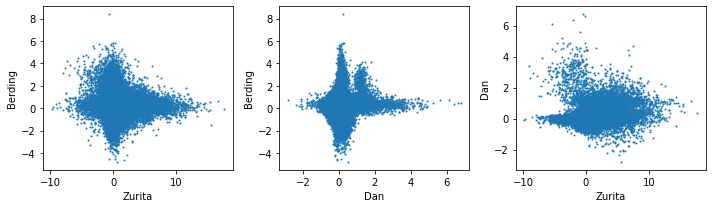

In [103]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].scatter(-z_diff.values, -b_diff.values, s=1)
ax[1].scatter(-d_diff.values, -b_diff.values, s=1)
ax[2].scatter(-z_diff.values, -d_diff.values, s=1)
ax[0].set_xlabel('Zurita')
ax[0].set_ylabel('Berding')
ax[1].set_xlabel('Dan')
ax[1].set_ylabel('Berding')
ax[2].set_xlabel('Zurita')
ax[2].set_ylabel('Dan')
plt.tight_layout()

In [104]:
z_mean = z_diff.reset_index().groupby('features').mean()['diff']
d_mean = d_diff.reset_index().groupby('features').mean()['diff']
b_mean = b_diff.reset_index().groupby('features').mean()['diff']

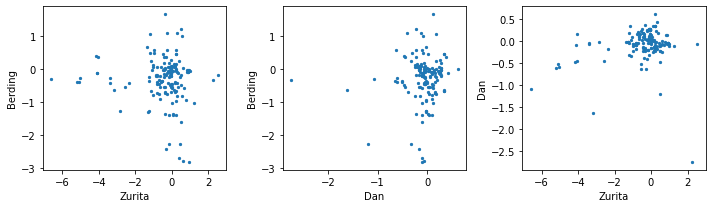

In [105]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].scatter(z_mean.values, b_mean.values, s=5)
ax[1].scatter(d_mean.values, b_mean.values, s=5)
ax[2].scatter(z_mean.values, d_mean.values, s=5)
ax[0].set_xlabel('Zurita')
ax[0].set_ylabel('Berding')
ax[1].set_xlabel('Dan')
ax[1].set_ylabel('Berding')
ax[2].set_xlabel('Zurita')
ax[2].set_ylabel('Dan')
plt.tight_layout()

Double check orientation

In [106]:
!ls ../data/amplicon_comparison/sample_metadata.txt

../data/amplicon_comparison/sample_metadata.txt


% accuracy 1.0


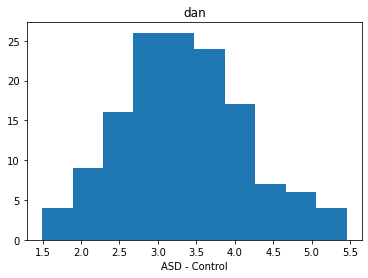

% accuracy 0.6818181818181818


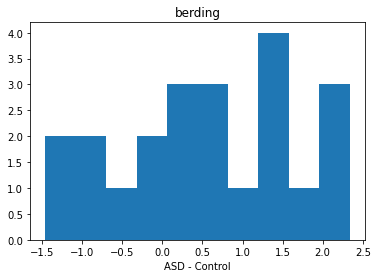

% accuracy 0.9545454545454546


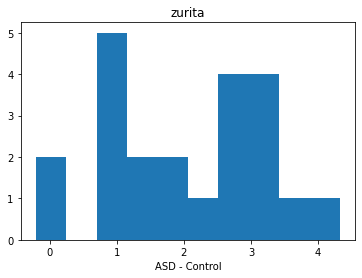

In [109]:
dirpath = '../data/amplicon_comparison'
md_ = pd.read_table(f'{dirpath}/sample_metadata.txt', index_col=0)

for fname in ['dan', 'berding', 'zurita']:
    table = biom.load_table(f'{dirpath}/{fname}.biom').to_dataframe().T
    md = md_.loc[table.index]

    pairs = []
    d_mean = z_mean.sort_values()
    for n, pair in md.groupby('Match_IDs'):
        p = pair.sort_values('Status')
        asd, control = p.index[0], p.index[1]
        top = d_mean.tail(20).index
        bot = d_mean.head(20).index
        lr = np.log(table.loc[asd, top] + 0.5).mean() - np.log(table.loc[control, bot] + 0.5).mean()
        pairs.append(lr)
    _ = plt.hist(pairs)
    plt.xlabel('ASD - Control')
    plt.title(fname)
    print('% accuracy', np.mean(np.array(pairs) > 0))
    plt.show()

Look into taxonomy

In [125]:
taxonomy = pd.read_table('~/databases/wol/taxonomy/ranks.tsv', index_col=0)
taxid = pd.read_table('~/databases/wol/taxonomy/taxid.map', header=None, dtype=str)
taxid.columns = ['GOTU', 'genome']
mapping = pd.merge(taxonomy, taxid, left_index=True, right_on='GOTU')
lookup = mapping[['GOTU', 'genome']].set_index('genome')

In [131]:
submapping = mapping.set_index('genome').loc[d_mean.index]
submapping['log_fold_change'] = d_mean
pd.set_option('display.max_rows', 200)

In [133]:
submapping.to_csv('amplicon_mapping.csv')

In [134]:
submapping

,kingdom,phylum,class,order,family,genus,species,GOTU,log_fold_change
genome,,,,,,,,,
1203606,Bacteria,Firmicutes,Clostridia,Clostridiales,Clostridiaceae,Butyricicoccus,Butyricicoccus pullicaecorum,G000398925,-6.609952
1437609,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,Bifidobacterium callitrichos,G000741175,-5.210446
1150423,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,Bifidobacterium dentium,G001042595,-5.102342
1147128,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,Bifidobacterium asteroides,G000304215,-5.059763
521003,Bacteria,Actinobacteria,Coriobacteriia,Coriobacteriales,Coriobacteriaceae,Collinsella,Collinsella intestinalis,G000156175,-4.179826
1151410,Bacteria,Firmicutes,Clostridia,Clostridiales,Peptostreptococcaceae,Clostridioides,Clostridioides difficile,G000450985,-4.097197
981539,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus gallolyticus,G000270145,-4.084664
445975,Bacteria,Actinobacteria,Coriobacteriia,Coriobacteriales,Coriobacteriaceae,Collinsella,Collinsella stercoris,G000156215,-4.052928
1117379,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,Bacillus bataviensis,G000307875,-3.402166
